# Sparkify: Predicting User Churn with PySpark

Sparkify is a digital music streaming service similar to Spotify or Pandora. Users can stream songs for free using the free tier that plays advertisements between songs or stream music without advertisements through the premium tier for a flat monthly fee. Users can upgrade, downgrade, or cancel their accounts at anytime. It is crucial for Sparkify's business to thrive that users love the service. If it could accurately identify users before they cancel, Sparkify could offer them incentives to stay.   
  
**Problem Statement**:  Sparkify wants to be able to predict which users are at risk to churn. A user has churned only when the user's account cancellation is confirmed. 
  
The purpose of this exercise is to find the fastest and most accurate model to run on the full dataset on a Spark cluster on AWS -- the best classifier and the best parameters. I expect that the number of churned users is far fewer than the number of users who stayed. So given the imbalance, I will be evaluating the models with f1 scores. In addition, I expect that data transformation required to generate features will be time consuming. I will attempt to find the fewest set of most important features necessary to predict which users will churn without sacrificing too much of the f1 score. 

# Imports

In [1]:
# # import libraries
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.functions import udf, avg, sum, min, max, count, col, filter, desc, when, dense_rank
from pyspark.sql.types import IntegerType
from pyspark.sql.window import Window

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Data
Data for this project was provided by Udacity.  Every time a user interacts with the Sparkify service, whether playing songs, seeing ads, changing their tier, it generates event data. The full dataset is 12GB and available in a Spark Cluster on AWS. However during the investigative portion of this assignment we will be working locally with a 128MB subset. 

The data contains the following demographic values:  
- userId (string) - unique identifier for the user  
- firstName (string) - user's first name  
- lastName (string) - user's last name  
- gender (string) - user's gender (M or F)  
- location (string) - user's location  
- userAgent (string) - user's browser/operating system  
- registration (int) - epoch timestamp of user's account registration  
- level (string) - user's subscription label (free or paid)  

The data contains the following event-level values:  
- artist (string) - artist name for song  
- song (string) - song name  
- length (float) - length of song in seconds  
- ts (int) - epoch timestamp of the log entry  
- page (string) - type of interaction of log, e.g. NextSong, Cancel, Home  
- auth (string) - authentication level (Logged In, Logged Out, Cancelled, or Guest)  
- sessionId (int) - unique identifier for the session  
- itemInSession (int) - log count in the session  
- method (string) - HTTP request method (GET or PUT)  
- status (int) - HTTP status code, (200, 307, 404)  

## Load & Preliminary Exploration 

In [3]:
data_path = "../data/mini_sparkify_event_data.json"
df = spark.read.json(data_path)
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
dfp = df.toPandas().replace('', np.nan)
dfp.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [5]:
dfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   artist         228108 non-null  object 
 1   auth           286500 non-null  object 
 2   firstName      278154 non-null  object 
 3   gender         278154 non-null  object 
 4   itemInSession  286500 non-null  int64  
 5   lastName       278154 non-null  object 
 6   length         228108 non-null  float64
 7   level          286500 non-null  object 
 8   location       278154 non-null  object 
 9   method         286500 non-null  object 
 10  page           286500 non-null  object 
 11  registration   278154 non-null  float64
 12  sessionId      286500 non-null  int64  
 13  song           228108 non-null  object 
 14  status         286500 non-null  int64  
 15  ts             286500 non-null  int64  
 16  userAgent      278154 non-null  object 
 17  userId         278154 non-nul

In [6]:
dfp.isnull().sum()

artist           58392
auth                 0
firstName         8346
gender            8346
itemInSession        0
lastName          8346
length           58392
level                0
location          8346
method               0
page                 0
registration      8346
sessionId            0
song             58392
status               0
ts                   0
userAgent         8346
userId            8346
dtype: int64

In [7]:
for col in dfp.columns:
    print(col, '\t', dfp[col].nunique())

artist 	 17655
auth 	 4
firstName 	 189
gender 	 2
itemInSession 	 1322
lastName 	 173
length 	 14865
level 	 2
location 	 114
method 	 2
page 	 22
registration 	 225
sessionId 	 2354
song 	 58480
status 	 3
ts 	 277447
userAgent 	 56
userId 	 225


In [8]:
for col in dfp.columns:
    if dfp[col].nunique() < 50:
        print(col, '\t', dfp[col].unique())

auth 	 ['Logged In' 'Logged Out' 'Cancelled' 'Guest']
gender 	 ['M' 'F' None]
level 	 ['paid' 'free']
method 	 ['PUT' 'GET']
page 	 ['NextSong' 'Add to Playlist' 'Roll Advert' 'Thumbs Up' 'Downgrade'
 'Thumbs Down' 'Home' 'Logout' 'Help' 'Login' 'Upgrade' 'Add Friend'
 'About' 'Settings' 'Submit Upgrade' 'Submit Downgrade' 'Error'
 'Save Settings' 'Cancel' 'Cancellation Confirmation' 'Register'
 'Submit Registration']
status 	 [200 307 404]


## Clean data set
Preliminary exploration of the data set found that there were data points that could not be attributed to any users vecause the `userId`s were empty strings. Those log entries can be cleaned out, as well as duplicates. 

In [9]:
# Delete rows with null `userId` or null `sessionId`
print('Before: ', (df.count(), len(df.columns)))
df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])

Before:  (286500, 18)


In [10]:
# Delete rows where `userId` is `''`
df = df.filter(df['userId'] != '')

In [11]:
# Drop duplicate rows
df = df.dropDuplicates()
print('After: ', (df.count(), len(df.columns)))

After:  (278154, 18)


## Data Extraction
To make exploratory analysis more digestible, I can already see that 4 data points should be transformed and simplified:  
- `location`: There are 114 different city for 225 unique users. Instead, lets investigate the users in aggregations by state.   
- `ts` and `registration`: are in epoch form. Converting them to date times and focusing on just the dates maybe give us more insights than timestamps.
- `useragent`: This column appears to track the operating system used to access the Sparkify service. Preliminary review of the values appear to show near duplications and overlap. So I will simplify this column by focusing on the operating systems brands. I should note that there appears to be a hybrid type of operating system that is "compatible" with multiple brands. For this project, I will make 'compatible' a separate category from 'Macintosh', 'Windows', and 'Linux'. 

In [12]:
# Extract States from Locations
extract_state = udf(lambda x: x.split(', ')[-1])
df = df.withColumn('state', extract_state('location'))

In [13]:
# Extract date from `registration` and `ts`
convert_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).date().strftime('%Y-%m-%d'))
df = df.withColumn('ts_date', convert_date('ts'))
df = df.withColumn('registration_date', convert_date('registration'))

In [14]:
# Extract OS brand 
def match_os_brand(useragent):
    '''
    useragent [string] = single value from the 'userAgent' column 
    Function to categorize the values in the 'userAgent' column
    os_brand [string] = 'compatible', 'Macintosh', 'Windows', or 'Linux'
    '''
    if 'compatible' in useragent:
        os_brand = 'compatible'
    elif 'Mac' in useragent:
        os_brand = 'Macintosh'
    elif 'Windows' in useragent:
        os_brand = 'Windows'
    else:
        os_brand = 'Linux'
    return os_brand
extract_os_brand = udf(lambda x: match_os_brand(x))
df = df.withColumn('os_brand', extract_os_brand('userAgent'))

# Exploratory Data Analysis
Exploring the full dataset would require excessive time and computation, so we will explore this subset here.  We will be looking at the difference between users who stayed and users who churned, the number of users who churned or stayed across the different events, how the users in the two different groups behaved, what events they created, and how that behavior changed over time. 

## Define Churn/Label
First, we need to create labels that we want our model to predict. Sparkify has asked us to predict the users who are at risk of churn. A user has churned only when the user's account cancellation is confirmed. So we will label `userId`s that have a log entry where the `page` value is `Cancellation Confirmation`. 

In [15]:
# Create 'Churn' label
boolean_churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('churn_event', boolean_churn('page'))

In [16]:
# label `userId` who churned 
user_window = Window.partitionBy("userId")
df = df.withColumn('user_churned', max('churn_event').over(user_window))

## Explore Data

In [17]:
dfp = df.toPandas()
dfp.sample(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,status,ts,userAgent,userId,state,ts_date,registration_date,os_brand,churn_event,user_churned
277871,Eric Church,Logged In,Anna,F,56,Williams,265.35138,free,"Charlotte-Concord-Gastonia, NC-SC",PUT,...,200,1540999781000,"""Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebK...",119,NC-SC,2018-10-31,2018-05-20,Windows,0,0
2251,Techno Animal,Logged In,Nicole,F,169,Beck,680.25424,paid,"Vineland-Bridgeton, NJ",PUT,...,200,1541737868000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",124,NJ,2018-11-08,2018-07-21,Macintosh,0,0
165888,None,Logged In,Sebastian,M,212,Wang,NaN,paid,"Jackson, MS",PUT,...,200,1541812488000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2...",53,MS,2018-11-09,2018-09-27,Macintosh,0,1
237348,None,Logged In,Nikolas,M,47,Olsen,NaN,free,"Oxnard-Thousand Oaks-Ventura, CA",PUT,...,307,1538580655000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:31....,121,CA,2018-10-03,2018-06-07,Linux,0,1
260519,White Rabbits,Logged In,Alyssa,F,143,Johnston,250.17424,paid,"Los Angeles-Long Beach-Anaheim, CA",PUT,...,200,1543478598000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,66,CA,2018-11-29,2018-07-26,Windows,0,0


### Number of Users who stayed vs who churned across categories
group by category & user id, count user ids

In [21]:
def visualize_binary_counts(drop_dupe_list, cols_to_group, category_labels):
    '''
    drop_dupe_list [list of strings] = list of column names to look for duplicates to drop
    cols_to_group [list of strings] = list of column names to group by
    category_labels [list of strings] = labels for the combinations of categories to be visualized
    Function to visualize count of users who churned and users who stayed across combinations of categories
    '''
    data = dfp.drop_duplicates(drop_dupe_list)\
              .groupby(cols_to_group)\
              ['userId'].count()
    ax = data.plot(kind='barh', figsize=(8,5)
                   , title='Count of Users per Category');
    for i, v in enumerate(data):
        ax.text(v + 3, i, str(v), color = 'red'
                , fontweight = 'bold', fontsize=15);
    ax.set_xlabel('Count of Users');
    ax.set_yticklabels(category_labels, rotation=0);
    ax.set_ylabel('Subscription Status');    

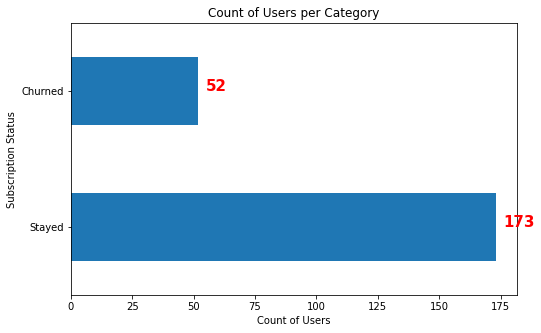

In [22]:
drop_dupe_list = ['userId']
cols_to_group = ['user_churned']
category_labels = ['Stayed', 'Churned']
visualize_binary_counts(drop_dupe_list, cols_to_group, category_labels)

As expected, users who churned only make about 23% of all the users in our data subset. This confirms that we will be attempting to predict an imbalanced class. 

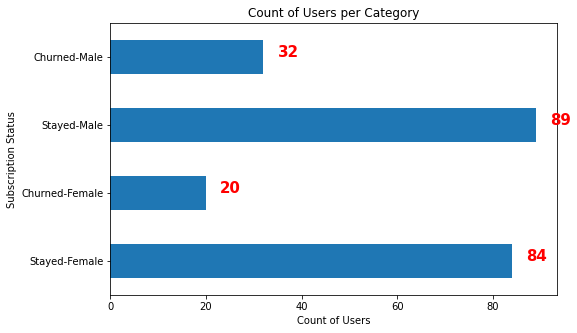

In [23]:
col_to_group = 'gender'
category_labels = ['Stayed-Female', 'Churned-Female', 'Stayed-Male', 'Churned-Male']
visualize_binary_counts(['userId', col_to_group], [col_to_group, 'user_churned'], category_labels)

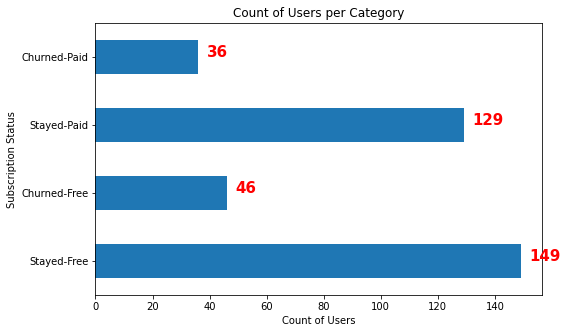

In [24]:
col_to_group = 'level'
category_labels = ['Stayed-Free', 'Churned-Free', 'Stayed-Paid', 'Churned-Paid']
visualize_binary_counts(['userId', col_to_group], [col_to_group, 'user_churned'], category_labels)

I'm surprised that there are more people who churned within the free tier, given that the service wasn't costing them. But because Sparkify allows their users to downgrade and upgrade at will, this visualization only represents a snapshot in time. This is data that I would love to see over time. 

### Number of Logs from Users who stayed vs churned across categories
group by category, count user ids

In [25]:
def groupby_cols_count(cols_to_group, col_to_count):
    '''
    cols_to_group [list of strings] = list of column names to group by
    col_to_count [string] = name of column to get a counts of values
    Function to count values in column for users who stayed and users who churned
    churned [pandas series] =  for users who churned, the count of values from the column counted
    stayed [pandas series] = for users who stayed, the count of values from the column counted
    '''
    churned = dfp[dfp['user_churned'] == 1].groupby(cols_to_group)[col_to_count].count() 
    stayed = dfp[dfp['user_churned'] == 0].groupby(cols_to_group)[col_to_count].count()   
    return churned, stayed

In [26]:
def scale_group(group):
    '''
    group [pandas series] = the count of values from a column counted
    Function to convert value counts into percentages 
    scaled_group [pandas series] = the percentages of the value counts
    '''
    scaled_group = group/group.sum()*100
    return scaled_group

In [74]:
def visualize_multi_frequency(cols_to_group, frequency_of_what, scaled=False, which_group='both'):
    '''
    cols_to_group [list of strings] = list of column names for the values we want to count 
    frequency_of_what [string] = label description for what the visualization is measuring frequency
    scaled [boolean] = if true, returns percentages. if false, returns counts.
    which_group [string] = 'stayed', 'churned', or 'both'
    '''
    churned, stayed = groupby_cols_count(cols_to_group, 'userId')
    frequency_label = 'Count'
    if scaled:
        churned = scale_group(churned)
        stayed = scale_group(stayed)
        frequency_label = 'Percent'
    
    users_df = pd.DataFrame({'Churned': churned,'Stayed':stayed})
    by_what = ' by Subscription Status'
    if which_group.lower() == 'stayed':
        users_df = pd.DataFrame({'Stayed':stayed})
        by_what = ' for Users who Stayed'
    elif which_group.lower() == 'churned':
        users_df = pd.DataFrame({'Churned': churned})
        by_what = ' for Users who Churned'
    else:
        pass
    
    ax = users_df.plot(kind='barh', figsize=(8,10));
    ax.set_xlabel(frequency_label + ' of ' + frequency_of_what);
    ax.set_title(frequency_label + ' of ' + frequency_of_what + by_what);    

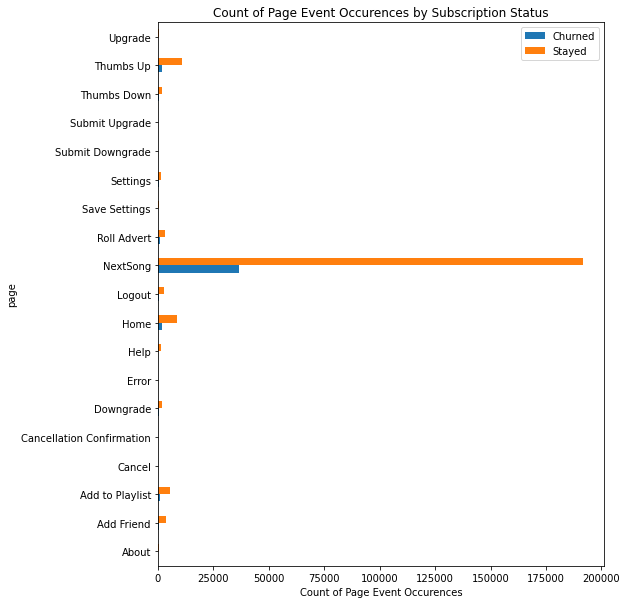

In [54]:
visualize_multi_frequency(['page'], 'Page Event Occurences', scaled=False)

The count of `NextSong` log entries within the `page` column is skewing the visualization. This is unsurprising given that the point of the service is to stream songs. However, I will remove it from the visualization to see how the other `page` values breakdown.

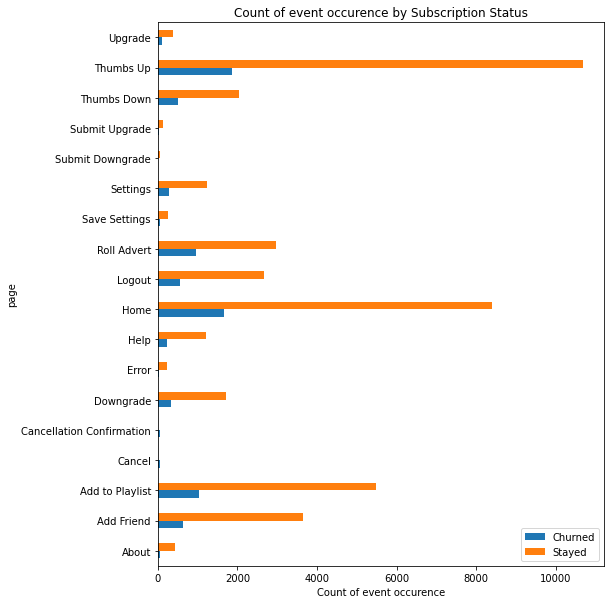

In [79]:
churned, stayed = groupby_cols_count(['page'], 'userId')

users_df = pd.DataFrame({'Churned': churned.drop('NextSong'),'Stayed':stayed.drop('NextSong')})
ax = users_df.plot(kind='barh', figsize=(8,10));
ax.set_xlabel('Count of event occurence')
ax.set_title('Count of event occurence by Subscription Status');

Without `NextSong` entries in the visualization, we can see that `Cancellation Confirmation` and `Cancel` are still rare occurances.  Also, I should note that these 2 values will need to be removed as features as these are basically the labels we want our models to predict.   
Interestingly, account `Downgrade`s are more associated with users who stayed than users who churned, indicating that those who churned may have either stayed in the free tier, therefore having no reason to downgrade their account, or churned while in the paid tier. In addition, it appears that none fo the user who churned encountered the `error` page.

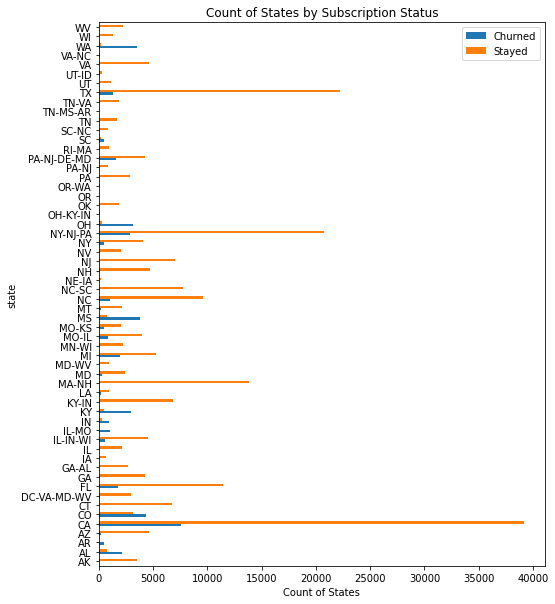

In [58]:
visualize_multi_frequency(['state'], 'States', scaled=False)

Obviously the `state` column will require further cleaning, and cursory review shows that we don't have users in all 50 states, i.e. Hawaii is not represented. CA and TX are interesting. We appare to have the most users from CA and TX. But cleary most of our churned users come from CA, and far fewer churned users come from TX. Let's see how the two groups break down in percentages. 

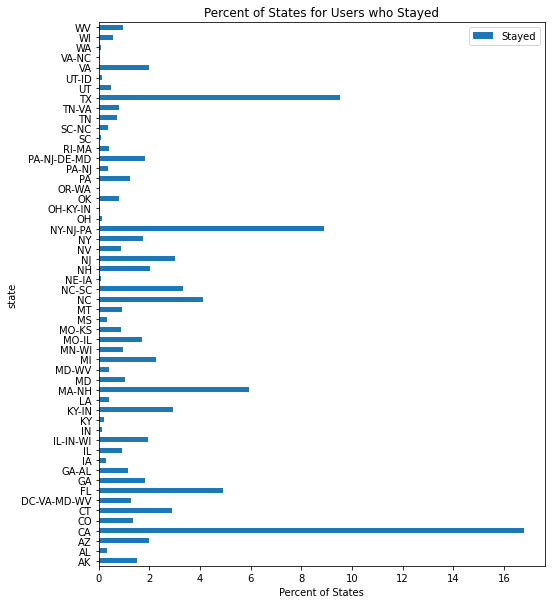

In [75]:
visualize_multi_frequency(['state'], 'States', scaled=True, which_group='stayed')

Most of the users who stayed come from TX, NY-NJ-PA, and CA.

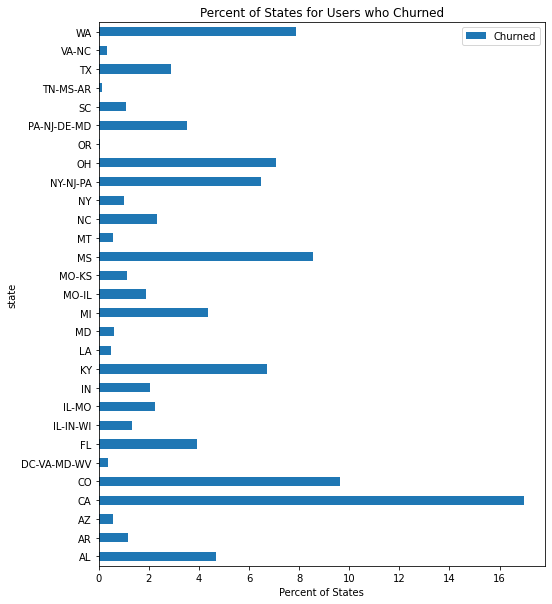

In [68]:
visualize_multi_frequency(['state'], 'States', scaled=True, which_group='churned')

Most of our churned users come from CA, Co, WA, and MS. TX makes up a much smaller portion of churned users, confirming that TX users disproportionately stay with Sparkify.

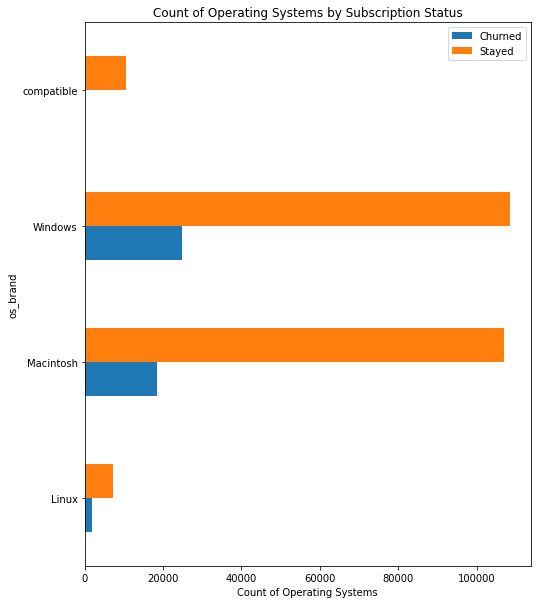

In [60]:
visualize_multi_frequency(['os_brand'], 'Operating Systems', scaled=False)

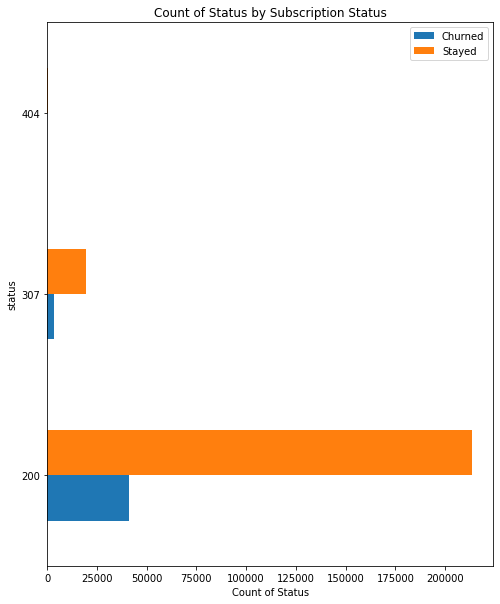

In [78]:
visualize_multi_frequency(['status'], 'Status', scaled=False)

`status` refers to the HTTP status codes of Sparkify service at the time of the log creation. `200` means that internet is connecting and it is expected to be the most frequent value and therefore skews the visualization. Lets rerun it without `200`.

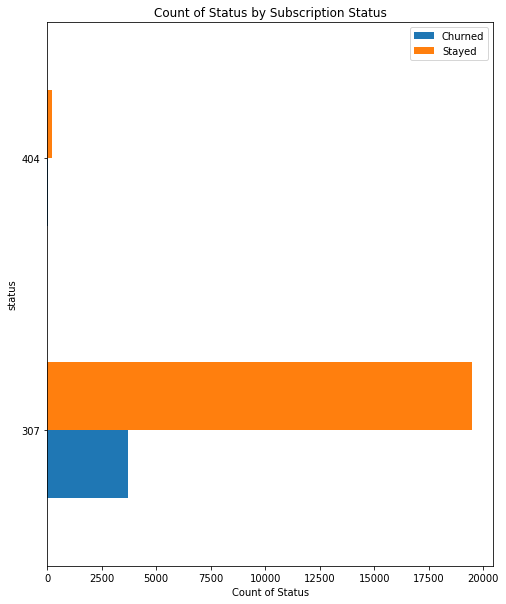

In [81]:
churned, stayed = groupby_cols_count(['status'], 'userId')

users_df = pd.DataFrame({'Churned': churned.drop(200),'Stayed':stayed.drop(200)})
ax = users_df.plot(kind='barh', figsize=(8,10));
ax.set_xlabel('Count of Status')
ax.set_title('Count of Status by Subscription Status');

`307` indicates that a page was redirected and `404` indicates an error. Unexpectedly, it doesn't appear that users who churned were those who encountered more service disruptions. 

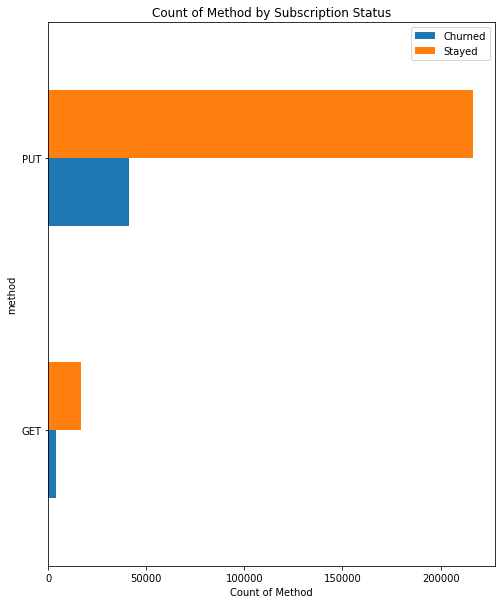

In [77]:
visualize_multi_frequency(['method'], 'Method', scaled=False)

### Behavior of users who stayed vs users who churned
groupby user ids, count across category

In [35]:
def visualize_hist_groups(churned_group, stayed_group, count_title):
    '''
    churned_group [pandas series] = count or sum of values for users who churned
    stayed_group [pandas series] = count or sum of values for users who stayed
    count_title [string] = Label describing what is being measured and what metric is used, i.e 'Count of Songs'
    Function to visualize count or sum of values for users who stayed and users who churned
    '''
    fig, ax = plt.subplots(figsize=(8,5));
    ax.hist([churned_group, stayed_group], label=['Churned', 'Stayed']);
    ax.legend(loc='upper right');
    ax.set_xlabel(count_title);
    ax.set_ylabel('Count of Users');
    ax.set_title('Count of Users by %s' % count_title);    

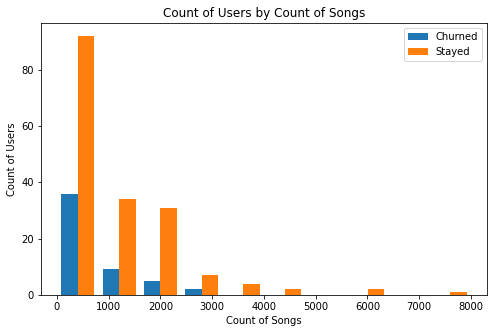

In [36]:
col_to_count = 'song'
cols_to_group = ['userId']
churned, stayed = groupby_cols_count(cols_to_group, col_to_count)
visualize_hist_groups(churned, stayed, 'Count of Songs')

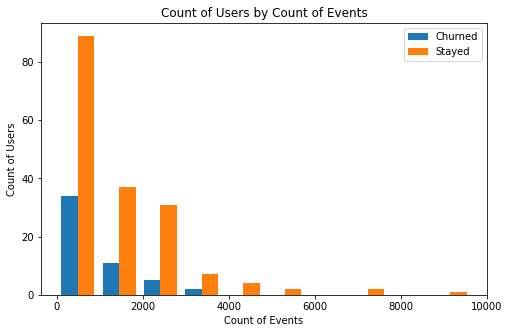

In [37]:
col_to_count = 'ts'
cols_to_group = ['userId']
churned, stayed = groupby_cols_count(cols_to_group, col_to_count)
visualize_hist_groups(churned, stayed, 'Count of Events')

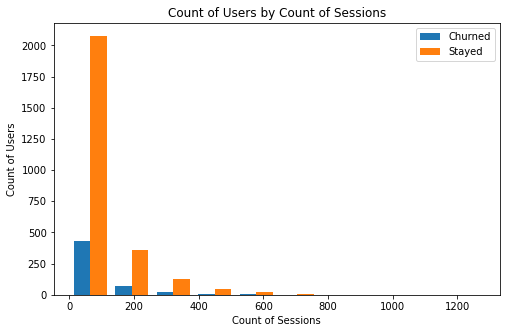

In [38]:
col_to_count = 'sessionId'
cols_to_group = ['userId', 'sessionId']
churned, stayed = groupby_cols_count(cols_to_group, col_to_count)
visualize_hist_groups(churned, stayed, 'Count of Sessions')

In [39]:
def groupby_userId_sum(col_to_sum):
    '''
    col_to_sum [string] = name of column to get sum of the values
    Function to sum values in column for users who stayed and users who churned
    churned [pandas series] =  for users who churned, the count of values from the column counted
    stayed [pandas series] = for users who stayed, the count of values from the column counted    
    '''
    churned = dfp[dfp['user_churned'] == 1].groupby(['userId'])[col_to_sum].sum()
    stayed = dfp[dfp['user_churned'] == 0].groupby(['userId'])[col_to_sum].sum()  
    return churned, stayed

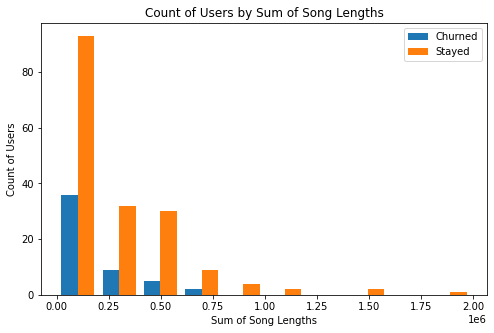

In [40]:
col_to_sum = 'length'
churned, stayed = groupby_userId_sum(col_to_sum)
visualize_hist_groups(churned, stayed, 'Sum of Song Lengths')

Unsurprisingly, users who stay play more songs, generate more log entries, and have more sessions. 

### Behavior of users who stayed vs users who churned across time
groupby user ids, count across category, across dates

In [41]:
def visualize_over_time(groups_df, y_label):
    '''
    groups_df [pandas dataframe] = dataframe of counts of userIds split into categories across dates
    y_label [string] = label describing what is being measure over time
    Function to visualize count of categories across dates
    '''
    ax = groups_df.plot(kind='line', figsize=(15,5));
    ax.set_ylabel(y_label);
    ax.get_xticklabels();
    ax.set_title(y_label+' over Time');    

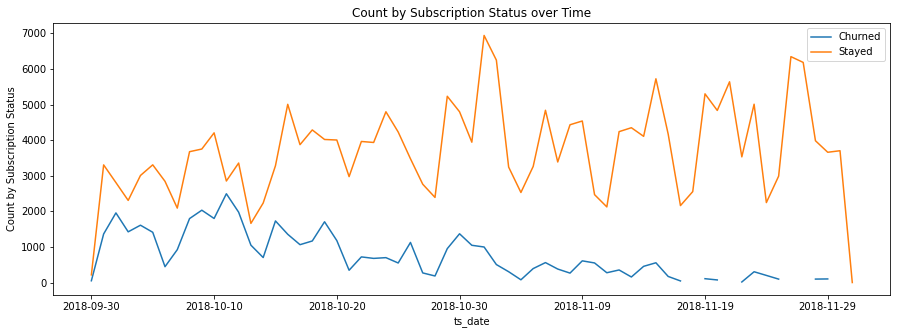

In [42]:
churned, stayed = groupby_cols_count(['ts_date'], 'userId')
groups_df = pd.DataFrame({'Churned': churned, 'Stayed': stayed})
visualize_over_time(groups_df, 'Count by Subscription Status')

There appears to be decline in the number of users who churn. But we don't have enough of a window to tell if this is cyclical. 

In [43]:
def binary_by_binary_groups_df(binary_col, date_type):
    '''
    binary_col [string] = name of column with binary values
    date_type [string] = name of column with datetime data
    Function to count users, split into different categories based on binary columns, over time
    groups_df [pandas dataframe] = dataframe of counts of userIds split into categories across date/time
    '''
    churned_binary0 = dfp[(dfp['user_churned'] == 1) & (dfp[binary_col]==dfp[binary_col].unique()[0])].groupby([date_type])['userId'].count()
    stayed_binary0 = dfp[(dfp['user_churned'] == 0) & (dfp[binary_col]==dfp[binary_col].unique()[0])].groupby([date_type])['userId'].count()
    churned_binary1 = dfp[(dfp['user_churned'] == 1) & (dfp[binary_col]==dfp[binary_col].unique()[1])].groupby([date_type])['userId'].count()
    stayed_binary1 = dfp[(dfp['user_churned'] == 0) & (dfp[binary_col]==dfp[binary_col].unique()[1])].groupby([date_type])['userId'].count()
    
    groups_df = pd.DataFrame({'Churned %s' %(dfp[binary_col].unique()[0]) : churned_binary0
                              , 'Stayed %s' %(dfp[binary_col].unique()[0]) : stayed_binary0
                              , 'Churned %s' %(dfp[binary_col].unique()[1]) : churned_binary1
                              , 'Stayed %s' %(dfp[binary_col].unique()[1]) : stayed_binary1})
    return groups_df

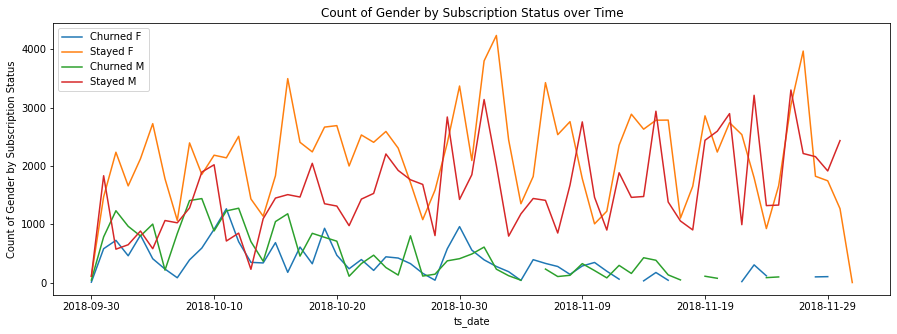

In [44]:
groups_df = binary_by_binary_groups_df('gender', 'ts_date')
visualize_over_time(groups_df, 'Count of Gender by Subscription Status')

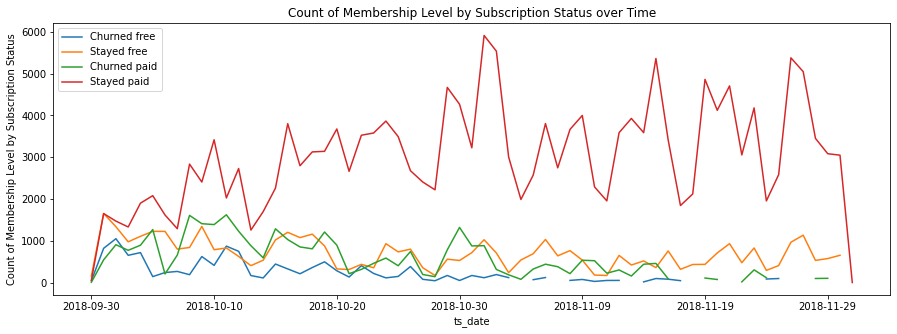

In [45]:
groups_df = binary_by_binary_groups_df('level', 'ts_date')
visualize_over_time(groups_df, 'Count of Membership Level by Subscription Status')

Interestingly, users who churned, regardless of tier, and users who stayed on the free tier are roughly similar. There are significantly more users who stayed on the paid tier, indicating that users maybe be more likely to stay if they are on paid tier. 

# Feature Engineering
I am anticipating that the data processing required to generate features will be the more time consuming aspect of this project. And we should aim to minimize this step for the full data set. As such, I plan to be more comprehensive with the features generate for the subset, and incorporate feature selection as part of the modeling experiments. 

## Generate labels

In [46]:
churned_users = df.select('userId', 'user_churned').dropDuplicates()
churned_users.describe().show()

+-------+------------------+------------------+
|summary|            userId|      user_churned|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|0.2311111111111111|
| stddev|105396.47791907164|0.4224832108996327|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



## Generate Features

In [76]:
def count_per_user(column, newcolumn):
    '''
    column [string] = name of column we want to count
    newcolumn [string] = new column name for the count for each user
    Function to count unique values in a column for each user into a new dataframe
    f_count [pyspark dataframe] = dataframe of userIds and count
    '''
    col_df = df.select('userId', column).dropDuplicates()
    f_count = col_df.groupby('userId').count().withColumnRenamed('count', newcolumn)
    return f_count

In [48]:
### Count of session per user
f_session_count = count_per_user('sessionId', 'session_count')
f_session_count.describe().show()

+-------+------------------+------------------+
|summary|            userId|     session_count|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|14.115555555555556|
| stddev|105396.47791907164|14.646884657111562|
|    min|                10|                 1|
|    max|                99|               107|
+-------+------------------+------------------+



In [49]:
### Count of songs
f_song_count = count_per_user('song', 'song_count')
f_song_count.describe().show()

+-------+------------------+-----------------+
|summary|            userId|       song_count|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|898.7866666666666|
| stddev|105396.47791907164|896.3920483168703|
|    min|                10|                4|
|    max|                99|             5947|
+-------+------------------+-----------------+



In [50]:
### Count of logs
f_event_count = count_per_user('ts', 'log_count')
f_event_count.describe().show()

+-------+------------------+------------------+
|summary|            userId|         log_count|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|1232.9288888888889|
| stddev|105396.47791907164|1326.7933296348353|
|    min|                10|                 6|
|    max|                99|              9606|
+-------+------------------+------------------+



In [51]:
### Count of artists
f_artist_count = count_per_user('artist', 'artist_count')
f_artist_count.describe().show()

+-------+------------------+-----------------+
|summary|            userId|     artist_count|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|697.3733333333333|
| stddev|105396.47791907164| 603.956976648881|
|    min|                10|                4|
|    max|                99|             3545|
+-------+------------------+-----------------+



In [52]:
### Total session duration per user
f_total_session_duration = df \
    .groupby('userId', 'sessionId') \
    .agg(((max('ts') - min('ts'))/1000).alias('session_length')) \
    .groupby('userId') \
    .agg(sum('session_length').alias('total_session_length'))
f_total_session_duration.describe().show()

+-------+------------------+--------------------+
|summary|            userId|total_session_length|
+-------+------------------+--------------------+
|  count|               225|                 225|
|   mean|65391.013333333336|  253672.41777777777|
| stddev|105396.47791907164|   275907.9025511626|
|    min|                10|               420.0|
|    max|                99|           1968410.0|
+-------+------------------+--------------------+



In [53]:
### Average session duration
f_avg_session_duration = df \
    .groupby('userId', 'sessionId') \
    .agg(((max('ts') - min('ts'))/1000).alias('session_length')) \
    .groupby('userId') \
    .agg(avg('session_length').alias('avg_session_length'))
f_avg_session_duration.describe().show()

+-------+------------------+------------------+
|summary|            userId|avg_session_length|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|   17289.959044401|
| stddev|105396.47791907164|10610.546683414272|
|    min|                10|             420.0|
|    max|                99|           70794.0|
+-------+------------------+------------------+



In [54]:
### Total song length per user
f_total_song_length = df\
    .where(df.page == 'NextSong')\
    .select('userId', 'length')\
    .groupBy('userId') \
    .sum() \
    .withColumnRenamed('sum(length)', 'total_song_length')
f_total_song_length.describe().show()

+-------+------------------+------------------+
|summary|            userId| total_song_length|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|252558.32065155558|
| stddev|105396.47791907164|275396.40388476383|
|    min|                10|         691.66884|
|    max|                99|1991154.9155800005|
+-------+------------------+------------------+



In [55]:
### Average song length per session
f_avg_song_length = df\
    .where(df.page == 'NextSong')\
    .groupby('userId', 'sessionId') \
    .agg(sum('length').alias('session_song_length'))\
    .groupby('userId') \
    .agg(avg('session_song_length').alias('avg_song_length'))
f_avg_song_length.describe().show()

+-------+------------------+------------------+
|summary|            userId|   avg_song_length|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336| 17619.42584386079|
| stddev|105396.47791907164|10604.654028520292|
|    min|                10|         691.66884|
|    max|                99|       71087.38675|
+-------+------------------+------------------+



In [56]:
def count_level(what_level, what_count, newcolumn):
    '''
    what_level [string] = 'free' or 'paid'
    what_count [string] = column name of unique values to count, dates or timestamps
    newcolumn ['string'] = new column name for the count for each user
    Function to count the number of logs or days each user was on the 'free' or 'paid' level
    f_level_count [pyspark dataframe] = data frame of userIds and count
    '''
    col_df = df.where(df.level == what_level).select('userId', what_count).dropDuplicates()
    f_level_count = col_df.groupby('userId').agg(count(what_count).alias(newcolumn))
    return f_level_count

In [57]:
### Count of logs as a free user
f_count_free_logs = count_level('free', 'ts', 'level_count_free_logs')
f_count_free_logs.describe().show()

+-------+------------------+---------------------+
|summary|            userId|level_count_free_logs|
+-------+------------------+---------------------+
|  count|               195|                  195|
|   mean|  61086.1641025641|     284.374358974359|
| stddev|101093.50762803684|    305.0420257660881|
|    min|               100|                    4|
|    max|                99|                 2039|
+-------+------------------+---------------------+



In [58]:
### Count of days as free user
f_count_free_days = count_level('free', 'ts_date', 'level_count_free_days')
f_count_free_days.describe().show()

+-------+------------------+---------------------+
|summary|            userId|level_count_free_days|
+-------+------------------+---------------------+
|  count|               195|                  195|
|   mean|  61086.1641025641|    6.523076923076923|
| stddev|101093.50762803684|    5.738568265819883|
|    min|               100|                    1|
|    max|                99|                   36|
+-------+------------------+---------------------+



In [59]:
### Count of logs as a paid user
f_count_paid_logs = count_level('paid', 'ts', 'level_count_paid_logs')
f_count_paid_logs.describe().show()

+-------+------------------+---------------------+
|summary|            userId|level_count_paid_logs|
+-------+------------------+---------------------+
|  count|               165|                  165|
|   mean| 69145.96363636364|   1345.2121212121212|
| stddev|111841.94919813269|   1265.8041683195336|
|    min|                10|                    1|
|    max|                99|                 7762|
+-------+------------------+---------------------+



In [60]:
### Count of days as a paid user
f_count_paid_days = count_level('paid', 'ts_date', 'level_count_paid_days')
f_count_paid_days.describe().show()

+-------+------------------+---------------------+
|summary|            userId|level_count_paid_days|
+-------+------------------+---------------------+
|  count|               165|                  165|
|   mean| 69145.96363636364|   12.309090909090909|
| stddev|111841.94919813269|    9.649098391988264|
|    min|                10|                    1|
|    max|                99|                   50|
+-------+------------------+---------------------+



In [61]:
def occurence_count_pivot(column):
    '''
    column [string] = name of column to count values
    Function to count the occurence of each value in the column for each user
    valuecount_cols [pyspark dataframe] = dataframe of userIds and count of occurence for every value
    '''
    col_df = df.groupby('userId', column).count()
    valuecount_cols = col_df.withColumn('pivot_col', functions.concat(functions.lit(column+'_count_'), col_df[column]))\
                     .groupby('userId').pivot('pivot_col').agg(functions.first('count')).fillna(0)
    return valuecount_cols

In [62]:
### Count of each method per user
f_method_counts = occurence_count_pivot('method')
f_method_counts.describe().show()

+-------+------------------+-----------------+------------------+
|summary|            userId| method_count_GET|  method_count_PUT|
+-------+------------------+-----------------+------------------+
|  count|               225|              225|               225|
|   mean|65391.013333333336|90.38222222222223|1145.8577777777778|
| stddev|105396.47791907164|87.49456944599297|1246.3151534926455|
|    min|                10|                0|                 3|
|    max|                99|              674|              8958|
+-------+------------------+-----------------+------------------+



In [63]:
### Count of each status per user
f_status_counts = occurence_count_pivot('status')
f_status_counts.describe().show()

+-------+------------------+------------------+------------------+------------------+
|summary|            userId|  status_count_200|  status_count_307|  status_count_404|
+-------+------------------+------------------+------------------+------------------+
|  count|               225|               225|               225|               225|
|   mean|65391.013333333336|           1132.08|            103.04|              1.12|
| stddev|105396.47791907164|1219.4779631055246|111.38672657522015|1.4726070176973318|
|    min|                10|                 6|                 0|                 0|
|    max|                99|              8909|               716|                 7|
+-------+------------------+------------------+------------------+------------------+



As noted earlier, `Cancellation Confirmation` is the label that we are predicting and should be removed as a feature. Users would not see the `Cancellation Confirmation` page without seeing the `Cancel` page first, so `Cancel` should also be removed as well.

In [64]:
### Count of each page per user
f_page_counts = occurence_count_pivot('page').drop('page_count_Cancellation Confirmation').drop('page_count_Cancel')
f_page_counts.describe().show()

+-------+------------------+------------------+---------------------+--------------------------+--------------------+------------------+------------------+-----------------+------------------+-------------------+----------------------+------------------------+-------------------+---------------------------+-------------------------+----------------------+--------------------+------------------+
|summary|            userId|  page_count_About|page_count_Add Friend|page_count_Add to Playlist|page_count_Downgrade|  page_count_Error|   page_count_Help|  page_count_Home| page_count_Logout|page_count_NextSong|page_count_Roll Advert|page_count_Save Settings|page_count_Settings|page_count_Submit Downgrade|page_count_Submit Upgrade|page_count_Thumbs Down|page_count_Thumbs Up|page_count_Upgrade|
+-------+------------------+------------------+---------------------+--------------------------+--------------------+------------------+------------------+-----------------+------------------+------------

## Dummy Categorical Features
The categorical variables need to be converted because the models only take numerical values. In addition, one value from each set of categories will need to be dropped to avoid multicollinearity in the models, especially logistic regression. In brief, mutlicollinearity among the features will lead to unstable estimates of the regression coefficiencts, which would make any feature importance calculations unreliable. 

In [65]:
### gender (dropping 'F')
col_df = df.select('userId', 'gender').dropDuplicates()
f_gender = col_df.replace({'M':'1', 'F':'0'}, subset='gender').withColumnRenamed('gender', 'gender_male')
f_gender = f_gender.withColumn('gender_male', f_gender['gender_male'].cast(IntegerType()))
f_gender.describe().show()

+-------+------------------+-------------------+
|summary|            userId|        gender_male|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336| 0.5377777777777778|
| stddev|105396.47791907165|0.49968243883744773|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



In [66]:
### last level (dropping 'free')
time_window = Window.partitionBy('userId').orderBy(desc('ts'))
df=df.withColumn('latest_time_rank', dense_rank().over(time_window))
col_df = df.filter(df.latest_time_rank == 1).select('userId', 'level').dropDuplicates()
f_last_level = col_df.replace({'paid':'1', 'free':'0'}, subset='level').withColumnRenamed('level', 'lastlevel_paid')
f_last_level = f_last_level.withColumn('lastlevel_paid', f_last_level['lastlevel_paid'].cast(IntegerType()))
f_last_level.describe().show()

+-------+------------------+------------------+
|summary|            userId|    lastlevel_paid|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|0.6444444444444445|
| stddev|105396.47791907164|0.4797486114192829|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



In [67]:
### state (all 50 states are not present here)
categories = list(set([state for states in [states.state.split('-') for states in df.select('state').distinct().collect()] for state in states]))
col_df = df.select('userId' ,'state').dropDuplicates()
dummy_states = [functions.when(functions.col('state').contains(category), 1).otherwise(0).alias('state_'+category) \
                for category in categories]
f_states = col_df.select('userId', *dummy_states)
f_states.describe().show()

+-------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+--------------------+------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+-------------------+--------------------+
|summary|            userId|           state_IL|          state_MO|    

I generated all 44 states just in case. I'm not sure if there will be a multicollinarity problem here because all 50 states aren't present here. Multicollinarity won't be an issue for tree based models as they would just drop duplicative features. However, if we proceed with a regression based model, I will review 2 versions of the model, one with all 44 states, one with only 43 states, and see if there is a change in performance. 

In [68]:
### os brand (dropped 'compatible')
categories = df.select('os_brand').distinct().rdd.flatMap(lambda x: x).collect()
col_df = df.select('userId', 'os_brand').dropDuplicates()
dummy_os = [functions.when(functions.col('os_brand')==category, 1).otherwise(0).alias('os_'+category) \
            for category in categories]
f_os_sys = col_df.select('userId', *dummy_os).drop('os_compatible')
f_os_sys.describe().show()

+-------+------------------+-------------------+-------------------+------------------+
|summary|            userId|       os_Macintosh|           os_Linux|        os_Windows|
+-------+------------------+-------------------+-------------------+------------------+
|  count|               225|                225|                225|               225|
|   mean|65391.013333333336| 0.4533333333333333|0.05333333333333334|0.4711111111111111|
| stddev|105396.47791907165|0.49892742100286636|0.22519832529192058| 0.500277700660121|
|    min|                10|                  0|                  0|                 0|
|    max|                99|                  1|                  1|                 1|
+-------+------------------+-------------------+-------------------+------------------+



## Create the Dataset

In [69]:
data = churned_users.join(f_session_count,'userId','outer') \
                    .join(f_artist_count,'userId','outer') \
                    .join(f_song_count,'userId','outer') \
                    .join(f_event_count,'userId','outer') \
                    .join(f_total_song_length,'userId','outer') \
                    .join(f_avg_song_length,'userId','outer') \
                    .join(f_total_session_duration,'userId','outer') \
                    .join(f_avg_session_duration,'userId','outer') \
                    .join(f_count_free_logs,'userId','outer') \
                    .join(f_count_free_days,'userId','outer') \
                    .join(f_count_paid_logs,'userId','outer') \
                    .join(f_count_paid_days,'userId','outer') \
                    .join(f_method_counts,'userId','outer') \
                    .join(f_status_counts,'userId','outer') \
                    .join(f_page_counts,'userId','outer') \
                    .join(f_gender,'userId','outer') \
                    .join(f_last_level,'userId','outer') \
                    .join(f_states,'userId','outer') \
                    .join(f_os_sys,'userId','outer') \
                    .dropDuplicates() \
                    .fillna(0)

In [70]:
print((data.count(), len(data.columns)))

(225, 85)


In [71]:
# Change the column names to strings without spaces
for col in data.columns:
    data = data.withColumnRenamed(col, col.replace(' ', '_').replace('.', '_'))
print(data.columns)

['userId', 'user_churned', 'session_count', 'artist_count', 'song_count', 'log_count', 'total_song_length', 'avg_song_length', 'total_session_length', 'avg_session_length', 'level_count_free_logs', 'level_count_free_days', 'level_count_paid_logs', 'level_count_paid_days', 'method_count_GET', 'method_count_PUT', 'status_count_200', 'status_count_307', 'status_count_404', 'page_count_About', 'page_count_Add_Friend', 'page_count_Add_to_Playlist', 'page_count_Downgrade', 'page_count_Error', 'page_count_Help', 'page_count_Home', 'page_count_Logout', 'page_count_NextSong', 'page_count_Roll_Advert', 'page_count_Save_Settings', 'page_count_Settings', 'page_count_Submit_Downgrade', 'page_count_Submit_Upgrade', 'page_count_Thumbs_Down', 'page_count_Thumbs_Up', 'page_count_Upgrade', 'gender_male', 'lastlevel_paid', 'state_IL', 'state_MO', 'state_NH', 'state_LA', 'state_NC', 'state_CO', 'state_SC', 'state_AZ', 'state_WV', 'state_FL', 'state_TN', 'state_NE', 'state_UT', 'state_MA', 'state_KS', 'sta

In [72]:
data.printSchema()

root
 |-- userId: string (nullable = true)
 |-- user_churned: integer (nullable = true)
 |-- session_count: long (nullable = true)
 |-- artist_count: long (nullable = true)
 |-- song_count: long (nullable = true)
 |-- log_count: long (nullable = true)
 |-- total_song_length: double (nullable = false)
 |-- avg_song_length: double (nullable = false)
 |-- total_session_length: double (nullable = false)
 |-- avg_session_length: double (nullable = false)
 |-- level_count_free_logs: long (nullable = true)
 |-- level_count_free_days: long (nullable = true)
 |-- level_count_paid_logs: long (nullable = true)
 |-- level_count_paid_days: long (nullable = true)
 |-- method_count_GET: long (nullable = true)
 |-- method_count_PUT: long (nullable = true)
 |-- status_count_200: long (nullable = true)
 |-- status_count_307: long (nullable = true)
 |-- status_count_404: long (nullable = true)
 |-- page_count_About: long (nullable = true)
 |-- page_count_Add_Friend: long (nullable = true)
 |-- page_count

## Save the Dataset
As expected, feature generation took a few hours. We will save the feature dataset to avoid having to process the data again.

In [73]:
# # Saving data as spark csvs
data.write.save('data/sparkify_data', format='csv', header=True)